In [28]:
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import json
import os 
from tqdm import tqdm
from torch.autograd import Variable
import matplotlib.pyplot as plt


In [29]:
# Load the pre-trained ResNet18 model
model = models.resnet18(pretrained=True)
model.eval()  # Set model to evaluation mode

/home/boron/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/boron/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]   
    )
])

In [31]:
with open("imagenet_class_index.json") as f:
    class_idx = json.load(f)
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
idx2synset = [class_idx[str(k)][0] for k in range(len(class_idx))]
id2label = {v[0]: v[1] for v in class_idx.values()}

imagenet_path = './imagenet_samples'

# List of image file paths
image_paths = os.listdir(imagenet_path)

print("ImagePaths: ", image_paths)

ImagePaths:  ['mountain_bike.JPEG', 'mousetrap.JPEG', 'paintbrush.JPEG', 'peacock.JPEG', 'piggy_bank.JPEG']


In [32]:
# code modified from https://github.com/kazuto1011/smoothgrad-pytorch/blob/master/smooth_grad.py 

def one_hot_gradient_class(idx, probs):
    one_hot = torch.FloatTensor(probs.size()[-1]).zero_()
    one_hot[idx] = 1
    return one_hot

def img_to_grayscale(img, percentile=99):
  img_2d = np.sum(img, axis=0)
  span = abs(np.percentile(img_2d, percentile))
  img_2d = np.clip(-(img_2d + span) / (2 * span), -1, 1) * 255
  return img_2d

def generate_smoothgrad(image, target_class, model, sigma, n_samples):
  grads = []
  image = image.data
  sigma = (image.max() - image.min()) * sigma
  total_gradients = np.zeros_like(image)

  for sample in tqdm(range(n_samples)):
    noise = np.random.normal(0, sigma, image.size()).astype(np.float32)
    noised_image = image + torch.from_numpy(noise)
    noised_image = Variable(noised_image, requires_grad=True)
    predictions = model.forward(noised_image)
    if noised_image.grad is not None:
      noised_image.grad.data.zero_()
    one_hot = one_hot_gradient_class(target_class, predictions)
    one_hot = torch.sum(one_hot * predictions)
    one_hot.backward(retain_graph=True)
    total_gradients += noised_image.grad.data.cpu().numpy()

  avg_gradients = total_gradients[0, :, :, :] / n_samples
  noise_map = img_to_grayscale(avg_gradients)
  return noise_map, avg_gradients

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:09<00:00,  5.04it/s]


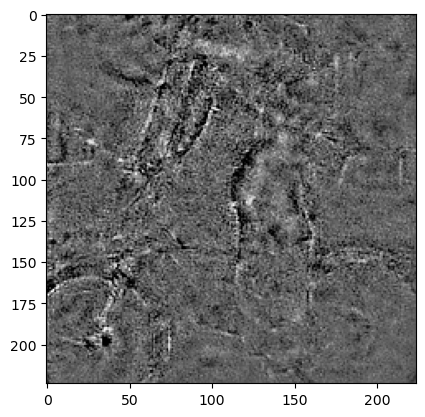

Predicted label: n03792782 (mountain_bike)


100%|██████████| 50/50 [00:10<00:00,  4.92it/s]


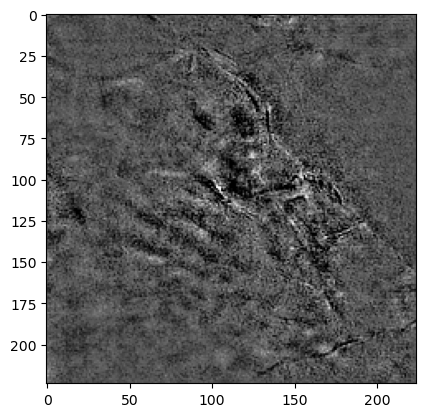

Predicted label: n03250847 (drumstick)


 62%|██████▏   | 31/50 [00:06<00:04,  4.68it/s]

In [33]:
target_classes = [674, 671, 719, 696, 84]
all_avg_gradients = []
# Iterate over the image paths
for img_path, target_class in zip(image_paths, target_classes):
    # Open  preprocess the image
    input_image = Image.open(img_path).convert('RGB')
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

    # Move the input and model to GPU if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    # Perform inference
    with torch.no_grad():
        output = model(input_batch)

    # Get the predicted class index
    _, predicted_idx = torch.max(output, 1)
    predicted_idx = predicted_idx.item()
    predicted_synset = idx2synset[predicted_idx]
    predicted_label = idx2label[predicted_idx]

    noised_img, avg_gradients = generate_smoothgrad(input_batch, target_class, model, 0.25, 50)
    all_avg_gradients.append(avg_gradients)
    plt.imshow(noised_img, cmap = 'Greys')
    plt.show()

    print(f"Predicted label: {predicted_synset} ({predicted_label})")
    # break